In [1]:
%load_ext autoreload
%autoreload 2

In [114]:
import molsysmt as msm
from uibcdf_test_systems.systems import DoubleWell
from uibcdf_test_systems.simulation import langevin_NVT
import simtk.unit as unit
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as ipywidgets

# The Markov state model and the Kinetic transition network of an assymetric double well potential.

The double well potential used here will be [the one included in the library UIBCDF_tests_systems](http://www.uibcdf.org/UIBCDF_test_systems/_build/systems/double_well_potential.html) with the following parameters:

In [3]:
double_well_asymmetric = DoubleWell(n_particles = 1, mass = 64 * unit.amu,
                                    Eo=4.0 * unit.kilocalories_per_mole,
                                    a=1.0 * unit.nanometers,
                                    b=0.25 * unit.kilocalories_per_mole)

Let's plot the potential energy along the coordinate X with $y=0$ and $z=0$:

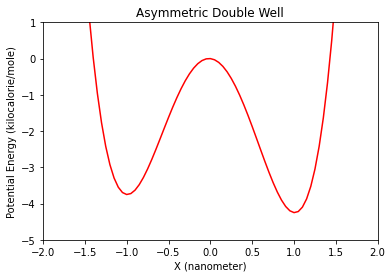

In [4]:
x_serie = np.arange(-2., 2., 0.05) * unit.nanometers
xyz_serie = np.zeros([x_serie.shape[0],3], dtype=float)* unit.nanometers
xyz_serie[:,0] = x_serie

U_x = double_well_asymmetric.potential_energy(xyz_serie)

plt.plot(x_serie, U_x, 'r-')
plt.ylim(-5,1)
plt.xlim(-2,2)
plt.xlabel("X ({})".format(unit.nanometers))
plt.ylabel("Potential Energy ({})".format(unit.kilocalories_per_mole))
plt.title("Asymmetric Double Well")
plt.show()

The object has some methods offering relevant information such as the position of the potential mimima and maxima:

In [5]:
double_well_asymmetric.coordinates_minima()

[Quantity(value=array([-0.99209399,  0.        ,  0.        ]), unit=nanometer),
 Quantity(value=array([1.00772281, 0.        , 0.        ]), unit=nanometer)]

In [6]:
double_well_asymmetric.coordinates_maxima()

[Quantity(value=array([-0.01562882,  0.        ,  0.        ]), unit=nanometer)]

And the oscillation time periods corresponding to the armonic approximation of each potential energy minima:

In [7]:
_, periods = double_well_asymmetric.armonic_oscillation_periods()

In [8]:
periods

[Quantity(value=array([4.3963326 , 4.34409214, 4.34409214]), unit=picosecond),
 Quantity(value=array([4.2944394 , 4.34409214, 4.34409214]), unit=picosecond)]

The above oscillation periods mark a time reference for the integration time step of a molecular dynamics. The integration time should be at least ten times smaller than the fastest oscillation.

Now we can produce a Langevin dynamics trajectory of the system at 300 K. The same UIBCDF_tests_systems library includes [OpenMM routines wrapped into methods to simulate quickly and effortless the test systems](http://www.uibcdf.org/UIBCDF_test_systems/_build/simulations/index.html). Let's then produce a 500 ns trajectory, saved every 5 ps, with an integration time of 0.2 ps.

In [9]:
temperature = 300 * unit.kelvin
integration_timestep = 0.2 * unit.picoseconds
saving_timestep = 5.0 * unit.picoseconds
total_time = 500 * unit.nanoseconds

initial_positions =  np.zeros([1, 3], np.float32) * unit.nanometers
initial_positions[0,0] = 1.0 * unit.nanometers

initial_velocities = np.zeros([1, 3], np.float32) * unit.nanometers/unit.picoseconds

time, traj, _, _, _ = langevin_NVT (double_well_asymmetric,
                                    temperature = temperature,
                                    friction = 5.0/unit.picoseconds,
                                    initial_positions = initial_positions,
                                    initial_velocities = initial_velocities,
                                    integration_timestep = integration_timestep,
                                    saving_timestep = saving_timestep,
                                    total_time = total_time)

100%|██████████| 99999/99999 [01:41<00:00, 981.03it/s] 


The next two figures show the X coordinate of the trajectory in time and its histogram:

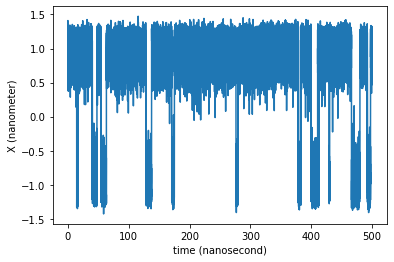

In [10]:
plt.plot(time.in_units_of(unit.nanoseconds), traj[:,0,0])
plt.xlabel('time ({})'.format(unit.nanoseconds))
plt.ylabel('X ({})'.format(traj.unit))
plt.show()

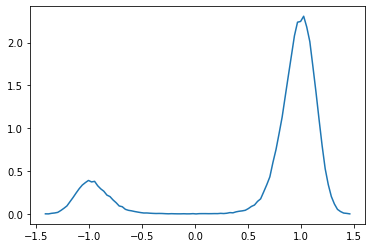

In [11]:
hist, bin_edges = np.histogram(traj[:,0,0],bins=100, density=True)
plt.plot((bin_edges[1:]+bin_edges[:-1])/2.0,hist)
plt.show()

More information on the behaviour of the double well potential can be found here and there.

## Discretizing the conformational space

For the shake of simplicity, we will consider along this notebook that our molecular system lives in a unidimensional coordinate space. Thus, the position of the particle is precised by only a float number, its X coordinate. Now, to build a Markov state model or a kinetic transition network we can not work with continuous coordinates. Segments of the conformational space need to be defined as conformational microstates. In case of having a single reaction coordinate or unique dimension, the discretization is simple. The set of microstates will be defined as contiguous not overlapping segments of length $\Delta x$.

Looking at the histogram of our trajectory, the system didn't visit the regions of the conformational space $x \in (-\infty,-2.0)$ and $x \in [2.0,\infty)$. It is sure that all microstates defined in those regions will not contribute to our Markov state model. Let's then discretize the interval $[-2.0, 2.0)$ in $N$ microstates with a width $\Delta x$. The microstates will be then labeled with an integer number $i$ between 0 and $N-1$ such that the bin of each microstate is defined as $[-2.0+i\Delta x, -2.0+(i+1)\Delta x)$:

In [12]:
lower_limit = -2.0 * unit.nanometers
upper_limit = 2.0 * unit.nanometers
N = 40
delta_x = (upper_limit-lower_limit)/N

The length $\Delta x$ is then:

In [13]:
print(delta_x)

0.1 nm


To work with these microstates in the following sections, two auxiliary arrays will be defined: an array with the edges of the microstates and another one with the middle point of each microstate.

In [14]:
mss_edges = np.linspace(lower_limit._value, upper_limit._value, N+1, True)
mss_edges = mss_edges*lower_limit.unit

In [15]:
mss_edges

Quantity(value=array([-2. , -1.9, -1.8, ...,  1.8,  1.9,  2. ]), unit=nanometer)

In [16]:
mss_mid_point = (mss_edges[1:]+mss_edges[:-1])/2.0

In [17]:
mss_mid_point

Quantity(value=array([-1.95, -1.85, -1.75, ...,  1.75,  1.85,  1.95]), unit=nanometer)

**Note**: At this point the effect of the number of microstates or their size on the Markov state model or the Kinetic transition network will not be a matter of discussion (see: XXX).

## Getting the discrete trajectory

### Time discretization

The trajectory is time discrete by definition. The molecular dynamics integrates the time evolution of a system at discrete time steps -integration time step-, and in addition, we don't usually store the positions of the system every integration time step. A longer saving time step is used to store a trajectory not too big with the time resolution small enough to observed the dynamical behavior of interest. Thus, the trajectory was discretized in time by construction. In our case, let's call the saving time step of our trajectory $\Delta t$. This will be then the smallest time step we can choose to build the Markov state model or the Kinetic transition network. But a longer time step can be used, always a multiple of the saving time step. Let's define time length $\tau=n_{t} \Delta t$, where $n_{t}$ is a positive integer number, as the time interval between consecutive frames used to build the model.

In our case, we will define $n_{t}=1$ so $\tau=\Delta t$:

In [18]:
n_t = 1
tau = n_t * saving_timestep

We will build a model with a trajectory extracted from our molecular dynamics with $T$ frames at time intervals of $\tau$ length: 

In [19]:
T = int(traj.shape[0]/n_t)
print(T,'frames')

100000 frames


In [20]:
print(tau, 'between frames')

5.0 ps between frames


Lets rewrite the trajectory object with the frames chosen to build the model:

In [21]:
traj = traj[::n_t,:]

In [22]:
traj.shape

(100000, 1, 3)

**Note**: At this point the effect of the $\tau$ chosen on the resulting Markov state model or the Kinetic transition network will not be a matter of discussion (see: XXX).

## Conformational discretization

The conformational space, a unidimensional coordinate space in this case, was fragmented into conformational microstates. The trajectory chosen to build the Markov state model or the Kinetic transition network can be re-written to store, instead of the continuous X coordinate, the index of the microstate visited at each frame:

In [23]:
discrete_traj = np.zeros([T], dtype=int)

for frame_index in range(T):
    aux_val = (traj[frame_index,0,0]-lower_limit)/delta_x
    mss_index = np.floor(aux_val).astype(int)
    discrete_traj[frame_index]=mss_index

In [24]:
discrete_traj

array([30, 29, 29, ..., 31, 29, 30])

Finnally, we already have the trajectory discretized in time and space. This can then be interpreted as a sequence of consecutive events in time -a Markov chain- with which a Markov state model or a Kinetic transition network can be build.

## The Markov state model or the Kinetic transition network

A set of events $\{A_{i}\}$, with $i=1,...N$, occurring in time can be observed as a sequence of $T$ consecutive events $S$ -a Markov chain- correspoding to $T$ observations made at time intervals of lenght $\tau$:

\begin{equation}
S=[ A_3, A_2, A_5, ..., A_1, A_7, A_3 ]
\end{equation}

Once and event $A_i$ has being observed, the probability of observing an event $A_j$ after a time interval $n_\tau \tau$, where $n_tau$ is a positive integer, is denoted by:

\begin{equation}
P(A_j, n_{\tau} \tau | A_i)
\end{equation}

This probability, also known as the conditional probability of getting $A_j$ after $\tau$ if the system was already at $A_i$, can be computed from the sequence $S$. This way the Markov chain is encoded as a matrix $P$ of conditional probabilities of shape $NxN$:

\begin{equation}
P(A_j, n_t \tau | A_i) = \frac{W(A_j,n_t\tau|A_i)_{S}}{w(A_i)_{S}}
\end{equation}

Where $w(A_i)_{S}$ is the number of times the event $A_i$ was observed along the sequence S, and $W(A_j,n_\tau \tau|A_i)_{S}$ is the number of times the event $A_i$ and $A_j$ happened consecutively, in this order, separated by $n_\tau$ observations of time $\tau$.

Thus:

\begin{equation}
\sum_j P(A_j, n_t \tau | A_i) = 1
\end{equation}

Once the conditional probabilities from a Markov chain, also known in this context as transition probabilities, have being defined, it can be proved that the conditional probabilities between more than two events can be computed from the conditional probabilities of consecutive events:

\begin{equation}
P(A_j, 2\tau | A_k, \tau | A_i) = P(A_j, \tau | A_k) P( A_k, \tau | A_i)
\end{equation}

This way, the conditional probability of observing the event $A_{j}$ after $2\tau$ of $A_{i}$ happened can be computed as:

\begin{equation}
P(A_j, 2\tau | A_i) = \sum_{k}P(A_j, \tau | A_k) P( A_k, \tau | A_i)
\end{equation}

The unconditional probability of observing the event $A_{i}$ at any observation is denoted as:

\begin{equation}
P(A_i)
\end{equation}

This probability can be computed from the Markov chain as:

\begin{equation}
P(A_i) = \frac{w(A_i)_{S}}{\sum_j w(A_j)_{S}} = \frac{w(A_i)_{S}}{T}
\end{equation}

Where $w(A_i)_{S}$ is the number of times the event $A_i$ was observed along the sequence S and $T$ is the total number of observations stored in the sequence, the length of S.

It is then clear that:

\begin{equation}
\sum_i P(A_i) = 1
\end{equation}


A Markov chain is called reversible if there exist a probability distribution $\pi_i$ such that:

\begin{equation}
P(A_j, \tau | A_i) \pi_i = P(A_i, \tau | A_j) \pi_j
\end{equation}

The distribution $\pi_i$ is also called the stationary probability distribution given that:

\begin{equation}
\pi_i = \sum_j P(A_i, \tau | A_j) \pi_j
\end{equation}

In the case of having a Markov chain reversible, the unconditional probability of observing $A_i$, $P(A_i)$, is equal to $\pi_i$. And this is the case of studing the trajectory of a molecular dynamics as markov chain.

Now that it has being introduced how a Markov chain can be translated into a set of transition probabilities. Let's turn our discrete trajectory into a Markov states model. In this case, since the chain will be time-homogeneous, once the time interval between observations was defined to produce the chain of events, we can write the conditional probabilities as:

\begin{equation}
P(A_j, \tau | A_i) \equiv P_{ji}
\end{equation}

## Number of visits or weight of a microstate

Lets call "weight of a microstate" as the number of times the trajectory visited a certain microstate. Lets collect from the trajectory these weights:

In [25]:
w=np.zeros([N], dtype=int)

for mss_index in discrete_traj:
    w[mss_index]+=1

In [26]:
w

array([0, 0, 0, ..., 0, 0, 0])

In any case, the sum of the weights of all microstates is equal to the number of trajectory frames:

In [27]:
np.sum(w)

100000

In [28]:
T

100000

Some of the microstates where not visited along the trajectory:

In [29]:
np.sum(w==0)

10

Plotting the weight of each microstate is straightforward:

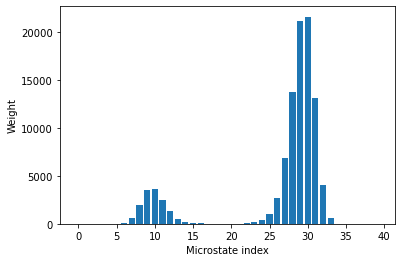

In [30]:
plt.bar(range(N), w)
plt.ylabel('Weight')
plt.xlabel('Microstate index')
plt.show()

In this unidimensional system, we can have an illustrative figure plotting the weights over the coordinate X. This time, instead of drawing steps or bars, the value of the weight will be given to the middle point of each bin:

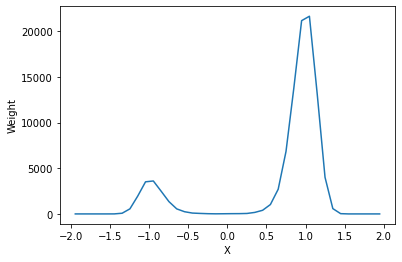

In [31]:
plt.plot(mss_mid_point, w)
plt.ylabel('Weight')
plt.xlabel('X')
plt.show()

## Occupation probability of a microstate

The system probability of being in a given microstate is obtained dividing its weight by the total number of frames, or the sum of all microstate weights:

In [32]:
pi = w/w.sum()

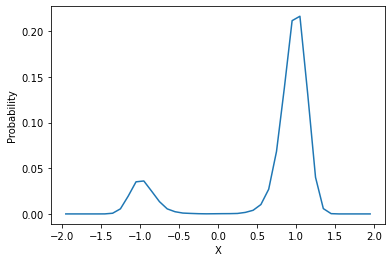

In [33]:
plt.plot(mss_mid_point, pi)
plt.ylabel('Probability')
plt.xlabel('X')
plt.show()

Keep in mind that this former plot shows the occupation probability of each microstate, and not the probability density function of the system in the X coordinate. In other words, this is not the probability of being in any x coordinate. Not even the probability of being in the middle point of each microstate. This is the probability $\pi_i$ of being in at any point in the segment of width $\Delta x$ corresponding to the microstate $i$.

## Number of times a transition between microstates is observed along the trajectory or weight of a transition between microstates.

With the microstates defined, a matrix storing the times a transition between microstates is observed along the trajectory can be defined. Lets name this matrix $W$. This way, the value $W_{ji}$ is the number of times the system went from bin $i$ to bin $j$ in a timestep of length $\tau$.

In [34]:
W = np.zeros([N, N], dtype=int)

In [35]:
for frame_index in range(T-1):
    ii = discrete_traj[frame_index]
    jj = discrete_traj[frame_index+1]
    W[jj, ii] += 1

In [36]:
W

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

Let's play a bit with the transitions matrix to be familiar with its meaning. For example, we can wonder how many different transitions $i$ to $j$ were observed along the trajectory compared with the total number of possible transitions in the space of discrete microstates.

In [37]:
N * N # number of possible transitions

1600

In [38]:
np.sum(W==0) # number of transitions visited at least once

1229

In [39]:
np.sum(W>0) # number of transitions not observed along the trajectory

371

Let's see now the number of times a transition was observed from a certain microstate $i$ to any other microstate including itself:

In [40]:
ii = 25
W[:, ii].sum()

1026

And let's see now the number of times a transitions was observed to the same certain microstate $i$ from any other microstate including itself:

In [41]:
W[ii,:].sum()

1026

And lets compare this with the number of times the microstate $i$ was visited along the trajectory:

In [42]:
w[ii]

1026

By construction, it is then true that for almost all $i$:

\begin{equation}
\sum_{j} W_{ij} = \sum_{j} W_{ji} = w_{i}
\end{equation}


The first microstate and the last microstate visited in the trajectory may have a hop on, or a hop off, more than the total number of reverse transitions. Again, by construction:

In [43]:
first_microstate = discrete_traj[0] # First microstate observed in the trajectory

In [44]:
W[first_microstate,:].sum()-W[:,first_microstate].sum()

0

In [45]:
W[first_microstate,:].sum()-w[first_microstate]

-1

And:

In [46]:
last_microstate = discrete_traj[-1] # First microstate observed in the trajectory

In [47]:
W[last_microstate,:].sum()-W[:,last_microstate].sum()

0

In [48]:
w[last_microstate]-W[:,last_microstate].sum()

1

The first microstate visited will have a hop on less to balance the number of hops off. The trajectory was already there when we started to count transitions. On the other side the last microstate visited in the trajectory will have a hop off less. The trajectory stopped there. But if the trajectory is long enough this differences will be statistically negligible.

If the trajectory is long enough, and thereby representative of the equilibrium, the number of times a transition $i \rightarrow j$ is observed should be equal to the number of times the system made the reverse transition $j \rightarrow i$. And thus the matrix $W$ should be simmetric. But in a real case it does only happen approximately. Actually, a matrix $W$ far from simmetricity could be interpreted as a symptom of having a trajectory  not capturing the equilibrium dynamics of the system.

In [49]:
W[7,12]

34

In [50]:
W[12,7]

35

Finnally, the weight of each transition out of a certain microstate $i$ to any $j$ can be plot:

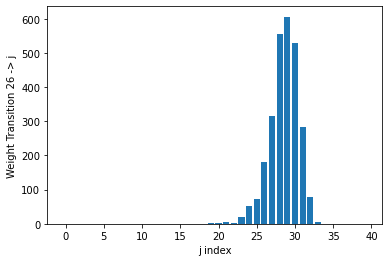

In [51]:
ii=26

plt.bar(range(N), W[:,ii])
plt.ylabel('Weight Transition {} -> j'.format(ii))
plt.xlabel('j index')
plt.show()

Or thanks to the fact that we can assign a representant point to each microstate, the middle point of the bin, we can plot the weigts of the these transitions over the X coordinate. The following figure shows these weights for the transitions out a microstate $i$ together with a vertical red stripe indicating the segment of X where $i$ is defined. In addition, the potential energy landscape is shown with a grey dashed line as reference:

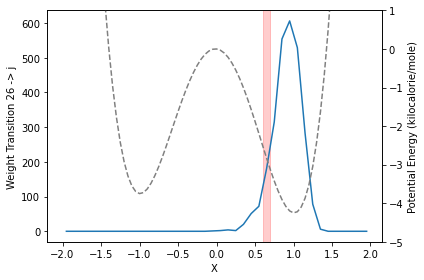

In [52]:
ii = 26

fig, ax1 = plt.subplots()

ax1.plot(mss_mid_point, W[:,ii])
ax1.axvspan(mss_edges[ii]._value, mss_edges[ii+1]._value, alpha=0.2, color='red')
ax1.set_ylabel('Weight Transition {} -> j'.format(ii))
ax1.set_xlabel('X')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.plot(x_serie, U_x, '--', c='0.5')
ax2.set_ylim(-5,1)
ax2.set_ylabel("Potential Energy ({})".format(unit.kilocalories_per_mole))

fig.tight_layout()
plt.show()

The transition weights can also be represented as a color code matrix:

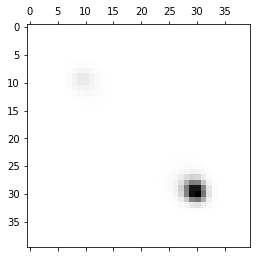

In [53]:
plt.matshow(W, cmap='Greys')
plt.show()

## Transition probabilities between microstates

Once the system is in the microstate $i$, the probability of visiting the microstate $j$ after a time interval $\tau$ is written as $P_{i,j}(\tau)$. $P_{i,j}(\tau)$ is called "transition probability" since it is the probability of going from one microstate to another after a certain time period. For each microstate $i$, the sum of all transition probabilities out $i$ is equal to one:

\begin{equation}
\sum_{j} P_{ji}(\tau) = 1
\end{equation}

Once the weights of the transitions have being computed, getting the transition probabilities is straightforward:

\begin{equation}
P_{ji} = \frac{W_{ji}}{\sum_{l} W_{li}} = \frac{W_{ji}}{w_{i}}
\end{equation}

Let's the get the transition probabilities from the transition weights stored in matrix $W$:

In [54]:
P = np.zeros([N,N], dtype=float)

for ii in range(N):
    if W[:,ii].sum()>0:
        P[:,ii] = W[:,ii]/W[:,ii].sum()

This way, by construction:

In [55]:
P[:,26].sum()

1.0

As we did before with the transition weights, we can represent the transition probabilities making use of the middle point of the bin associated to each microstate. The following figure shows the transition probabilities of the microstate $i$ to any other microstate. A red vertical strip indicates the extension of the microstate $i$ along X, and the grey dashed line represents the underlaying potential energy for reference:

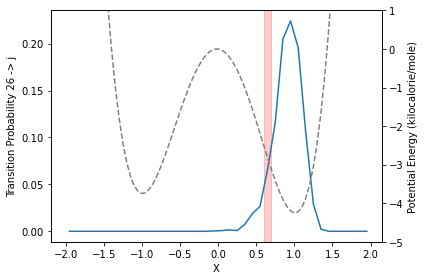

In [56]:
ii = 26

fig, ax1 = plt.subplots()

ax1.plot(mss_mid_point, P[:,ii])
ax1.axvspan(mss_edges[ii]._value, mss_edges[ii+1]._value, alpha=0.2, color='red')
ax1.set_ylabel('Transition Probability {} -> j'.format(ii))
ax1.set_xlabel('X')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.plot(x_serie, U_x, '--', c='0.5')
ax2.set_ylim(-5,1)
ax2.set_ylabel("Potential Energy ({})".format(unit.kilocalories_per_mole))

fig.tight_layout()
plt.show()

The transition probability matrix can also be represented as a 2D plot in grey scale color code:

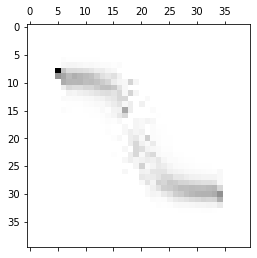

In [57]:
plt.matshow(P, cmap='Greys')
plt.show()

## Detailed balance condition on the discrete kinetic model

If the trajectory is large enough, close to capture equilibrium, the number of times the system went from $i$ to $j$ is equal to the number of times the system went from $j$ to $i$ for all microstates $i$ and $j$. This is known us the "detailed balance" condition:

\begin{equation}
W_{ji} = W_{ij}
\end{equation}

Which written in terms of the transition probabilities:

\begin{equation}
P_{ji} w_{i} = P_{ij} w_{j}
\end{equation}

And writting the number of visits in each microstate using the occupation probability:

\begin{equation}
P_{ji} \pi_{i} T = P_{ij} \pi_{j} T
\end{equation}

Which leaves us with the detalied balance condition written in terms of the occupation and transition probability:

\begin{equation}
P_{ji} \pi_{i} = P_{ij} \pi_{j}
\end{equation}

## The transition probability matrix as a time evolution operator or propagator

The transition probability matrix represents a model for the thermodynamics and kinetics of our molecular system. As a mathematical matrix, $P$ can be understood as an operator which function is propagating a probability distribution a single $\tau$ time step. Let's define, for example, an initial distribution for the microstates which contains all probability in a single microstate $i$ that you can choose:

In [59]:
ii = 30
p0 = np.zeros([N], dtype=float)
p0[ii] = 1.0

The system is initially in the $i$ macrostate with a probability $p_i=1.0$. There is no probability to observe the system in any other microstate at t=0. Now, if we let the time runs, the system has to evolve according to what is dictated by the transition matrix $P$:

\begin{equation}
p_i(\tau) = \sum_j P_{ij} p_j(0)
\end{equation}

Lets calculate this way the probability distribution at $t=\tau$:

In [62]:
ptau = np.zeros([N], dtype=float)

for ii in range(N):
    for jj in range(N):
        ptau[jj]+=P[jj,ii]*p0[ii]

Let's show over X, using the middle points of the microstates, how the initial probability distribution evolved in a time \tau:

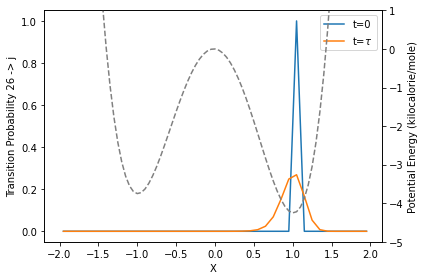

In [75]:
fig, ax1 = plt.subplots()

ax1.plot(mss_mid_point, p0, label='t=0')
ax1.plot(mss_mid_point, ptau, label=r't=$\tau$')
ax1.set_ylabel('Transition Probability {} -> j'.format(ii))
ax1.set_xlabel('X')
ax1.legend()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.plot(x_serie, U_x, '--', c='0.5')
ax2.set_ylim(-5,1)
ax2.set_ylabel("Potential Energy ({})".format(unit.kilocalories_per_mole))

fig.tight_layout()
plt.show()

If you observed carefully the loops to propagate the distribution with the transition probability values $Pij$, what we are doing is the definition of mathematical multiplication of a Matrix and a vector this way:

\begin{equation}
\vec{p}(t+\tau)=P\cdot \vec{p}(t)
\end{equation}

There is a numpy method to do this avoiding the loops:

In [76]:
ptau = np.matmul(P,p0)

We can then iterate this multiplication to observe the time evolution of the occupation probability of the system in each microstate starting with an initial conditions. Let's propagate the probability along $f$ time steps, and let's store how the probability is at each integration time:

In [112]:
ii = 10
p = np.zeros([N], dtype=float)
p[ii] = 1.0

f = 8000
ps = np.zeros([f,N], dtype=float)
ps[0,:] = p[:]

for step in range(1,f):
    p = np.matmul(P,p)
    ps[step,:]=p[:]

Let's see how the probability distribution evolved in time. A slide bar can be added to the plot to choose the time step to be shown:

In [144]:
def figure_probability_distribution(step=0):

    fig, ax1 = plt.subplots()

    ax1.plot(mss_mid_point, ps[step,:], label=r't={}$\tau$'.format(step))
    ax1.plot(mss_mid_point, pi, ':', c='C0')
    ax1.set_ylabel('Probability')
    ax1.set_xlabel('X')
    ax1.set_ylim([0.0, 1.1])
    ax1.legend()

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    ax2.plot(x_serie, U_x, '--', c='0.5')
    ax2.set_ylim(-5,1)
    ax2.set_ylabel("Potential Energy ({})".format(unit.kilocalories_per_mole))

    fig.tight_layout()
    plt.show()

interactive_plot = ipywidgets.interactive(figure_probability_distribution, step=(0, f-1, 1))
interactive_plot.children[-1].layout.height = '350px'
interactive_plot.children[0].layout.width = '100%'
interactive_plot

interactive(children=(IntSlider(value=0, description='step', layout=Layout(width='100%'), max=7999), Output(la…

As it can be observed in the above interactive figure, there is an initial phase where the well containing the initial microstate relaxes placing probability in its microstates. This happens quickly. After that the probability of this well decreases while the probability of the microstates on the other well increases. Like in a communicating vessels game. Finnally, the distribution probability appears to change slightly in time, approaching asymptotically the stationary distribution $\pi$ (dotted blue line).

## The stationary probability distribution and the relaxation modes

The transition probability matrix has an stationary solutions. Meaning that there is a probability distribution invariant under $P$:

\begin{equation}
\vec{\pi} = P \vec{\pi} 
\end{equation}

This distribution $\vec{\pi}$ is what is called the equilibrium distribution. The system adopts a probability to be in each microstate invariant in time, stationary, in equilibrium. Mathematically speaking, $\vec{\pi}$ is an eigenvector of $P$ with eigenvalue $\lambda = 1$:

In [188]:
eigenvalues, eigenvectors = np.linalg.eig(P)

Our matrix $P$ has columns with all probabilities equal to zero. The matrix will have then complex eigenvalues with its real part very close to zero.

In [189]:
np.isreal(eigenvalues).sum() # Number of real eigenvalues

22

In [190]:
np.iscomplex(eigenvalues).sum() # Number of complex eigenvalues

18

Let's plot the real part of all eigenvalues:

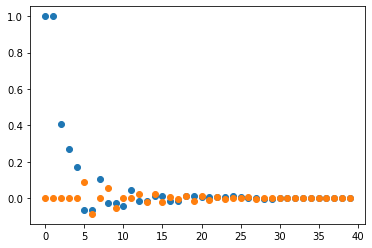

In [191]:
plt.scatter(range(N), eigenvalues.real)
plt.scatter(range(N), eigenvalues.imag)
plt.show()

There are two eigenvalues close to 1, the first two. Let's see the shape of the corresponding eigenvectors:

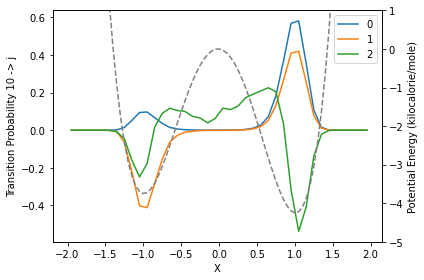

In [207]:
fig, ax1 = plt.subplots()

ax1.plot(mss_mid_point, eigenvectors[:,0].real, label='0')
ax1.plot(mss_mid_point, eigenvectors[:,1].real, label='1')
ax1.plot(mss_mid_point, eigenvectors[:,2].real, label='2')
ax1.set_ylabel('Transition Probability {} -> j'.format(ii))
ax1.set_xlabel('X')
ax1.legend()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.plot(x_serie, U_x, '--', c='0.5')
ax2.set_ylim(-5,1)
ax2.set_ylabel("Potential Energy ({})".format(unit.kilocalories_per_mole))

fig.tight_layout()
plt.show()

## Automatic metastable states decomposition

## Kinetic transition network

TODO